Перед вами таблица с результатами A/B-теста. В числовой колонке показаны значения выручки по каждому пользователю за период эксперимента.

Задача
Нужно понять, стали ли мы больше зарабатывать с пользователя или нет. Вы уже знаете о существовании t-теста, U-теста Mann-Whitney и бутстрапа. Открытый вопрос: какой инструмент использовать?

1. Посчитайте p-value тремя способами: t-тест, U-тест, бутстрап средних

2. Сравните результат между тестом и контролем по всем этим кейсам

3. Напишите выводы, которые можно сделать на основе анализа примененных критериев. Напишите, почему мы должны использовать тот или иной инструмент: каких предположений о случайной величине нужно придерживаться, какие условия необходимы и т.п.

Загрузим необходимые библиотеки, и сами данные и преведем их в "рабочий вид"

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

plt.style.use('ggplot')

In [2]:
import scipy.stats as st
import seaborn as sns
sns.set(rc={'figure.figsize': (12,6)}, style="whitegrid")

In [3]:
import pingouin as pg

In [7]:
hw = pd.read_csv('hw_bootstrap.csv', index_col=0, sep =';', decimal=',') 

In [8]:
hw.head()

,value,experimentVariant
1,10.380495,Control
2,9.546867,Control
3,11.088215,Control
4,10.147274,Control
5,9.789808,Control


In [9]:
hw.dtypes

value                float64
experimentVariant     object
dtype: object

In [10]:
hw.shape

(1000, 2)

In [13]:
hw.groupby('experimentVariant').size()
#находим количество наблюдений в контроле и эксп. группе

experimentVariant
Control      500
Treatment    500
dtype: int64

Теперь определимся с гипотезами

Нулевая гипотеза (H0): Разницы между средним value в тестовой и контрольной группе нет (зарабатывать больше не стали)

Альтернативная гипотеза (H1): Разница между средним value в тестовой и контрольной группе есть (стали больше зарабатывать)

Определяем альфа = 0.05

Проведем небольшой EDA

Изучаем распределение на нормальность в тесте и эксп. группе

In [15]:
pg.normality(data=hw, dv='value', group='experimentVariant') 
#метод чувствительный на кол-во наблюдений в выборке (но она у нас небольшая)

,W,pval,normal
experimentVariant,,,
Control,0.995925,2.241637e-01,True
Treatment,0.070389,1.093013e-43,False


In [17]:
#проведем дополнительный тест
pg.normality(data=hw, dv='value', group='experimentVariant', method='normaltest')

,W,pval,normal
experimentVariant,,,
Control,2.943459,2.295282e-01,True
Treatment,929.515767,1.439514e-202,False


По результатам теста распределение (Treatment) нормальным не является.

Посмотрим на эти распределения

Используем вариант с qq плотами

<AxesSubplot:xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

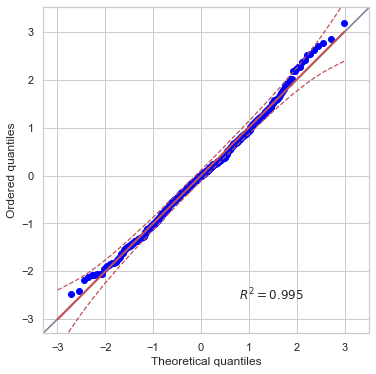

In [18]:
pg.qqplot(hw.query("experimentVariant == 'Control'").value)

Если график лежит на одной линии, то распределение можно считать нормальным. Но все таки есть небольшие отклонения от нормы

<AxesSubplot:xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

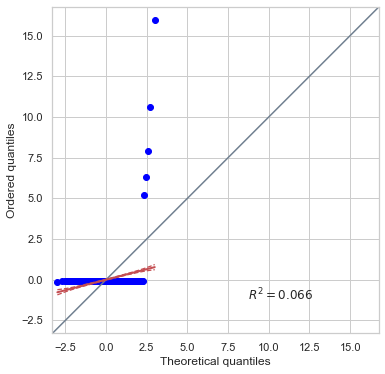

In [19]:
pg.qqplot(hw.query("experimentVariant == 'Treatment'").value)

По результатам теста распределение (Treatment) нормальным не является.
Очевидно что есть выбросы. 

Рассмотрим поподробнее

In [22]:
hw[hw.experimentVariant == 'Treatment'].value.describe()

count     500.000000
mean       27.321499
std       186.557011
min         6.436541
25%         9.421968
50%        10.025847
75%        10.675721
max      3000.000000
Name: value, dtype: float64

Сделаем небольшой вывод.

ВЫВОД: t-тест восприимчив в к выбросам. Если мы не отбросим выбросы, то использование t-теста неккоректно

In [25]:
hw.tail() #видим что у нас есть аномальные значения

,value,experimentVariant
996,1000.0,Treatment
997,1200.0,Treatment
998,1500.0,Treatment
999,2000.0,Treatment
1000,3000.0,Treatment


In [27]:
hw[hw.experimentVariant == 'Treatment'].value.quantile(.99)

22.999042271425807

99% наблюдений value < 22.99. У нас точно есть выбросы. Давайте попробуем избавиться от них, перезаписать в отдельную переменную

In [28]:
t = hw[(hw.experimentVariant == 'Treatment')]

In [29]:
t = t[t.value <= t.value.quantile(.99)].value

In [30]:
c = hw[hw.experimentVariant == 'Control'].value #для удобства перезапишем в отдельную переменную Control

Теперь посмотрим на распределения, исп hist

<AxesSubplot:>

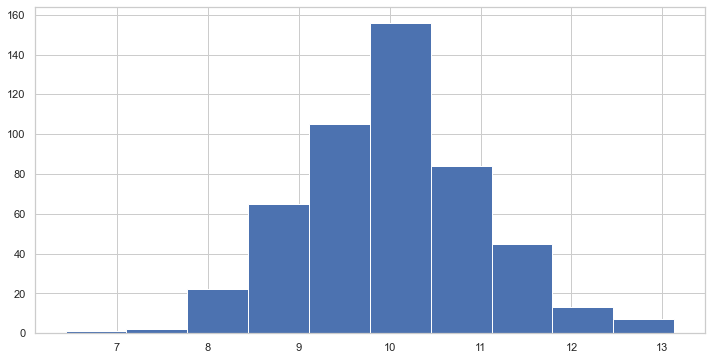

In [31]:
c.hist() #Control

<AxesSubplot:>

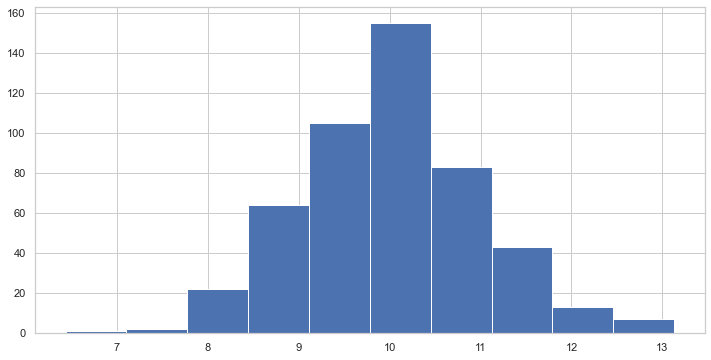

In [32]:
t.hist() #Treatment

In [33]:
t.min(), t.max()

(6.43654075863162, 13.130345728722)

In [34]:
c.min(), c.max()

(6.43654075863162, 13.130345728722)

Выкинули выбросы. И видно, что выборки то одинаковые

Теперь проведем t-test

In [36]:
from scipy.stats import ttest_ind

In [87]:
# не выкинули выбросы
ttest_ind(hw[hw.experimentVariant == 'Treatment'].value, hw[hw.experimentVariant == 'Control'].value, alternative='two-sided')

Ttest_indResult(statistic=2.0729020485356604, pvalue=0.038437593613498765)

In [88]:
# выкинули выбросы
ttest_ind(c, t, alternative='two-sided', equal_var=False)

Ttest_indResult(statistic=0.08299187901942148, pvalue=0.9338747244170571)

Нулевая гипотеза (H0): Разницы между средним value в тестовой и контрольной группе нет (зарабатывать больше не стали)

p > 0.05 . нулевую гипотезу не отвергаем

 U-тест Mann-Whitney

In [65]:
from scipy.stats import mannwhitneyu

In [89]:
# не выкинули выбросы
mannwhitneyu(hw[hw.experimentVariant == 'Treatment'].value, hw[hw.experimentVariant == 'Control'].value, alternative='two-sided')

MannwhitneyuResult(statistic=125810.5, pvalue=0.8592148582485579)

In [91]:
# выкинули выбросы
mannwhitneyu(t, c, alternative='two-sided')

MannwhitneyuResult(statistic=123310.5, pvalue=0.9228386264147465)

U-тест Mann-Whitney- не чувствителен к выбросам

БУТСТРАП

In [71]:
#создаем функцию

In [72]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

In [73]:
# будем пробовать бутстрап на эксп. распределении
np.random.seed(5)

In [74]:
n = 1000

sample_1 = np.random.exponential(scale=1/0.001, size=n)
sample_2 = np.random.exponential(scale=1/0.001, size=n)

df = pd.DataFrame({
    "sample_1": sample_1,
    "sample_2": sample_2
})

Проведем бустрап анализ среднего на исходных данных

  0%|          | 0/1000 [00:00<?, ?it/s]

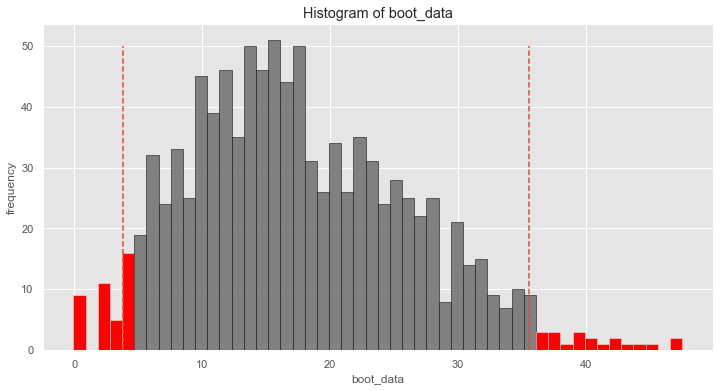

In [92]:
booted_data = get_bootstrap(hw[hw.experimentVariant == 'Treatment'].value, hw[hw.experimentVariant == 'Control'].value)

In [93]:
booted_data["p_value"] # альфа

0.04181076706580343

Исходя из полученных данных, мы не можем отвергать альт.гипотезу(H1)

Что-то пошло не так

Проведем бустрап анализ среднего на данных из которых исключили выбросы

  0%|          | 0/1000 [00:00<?, ?it/s]

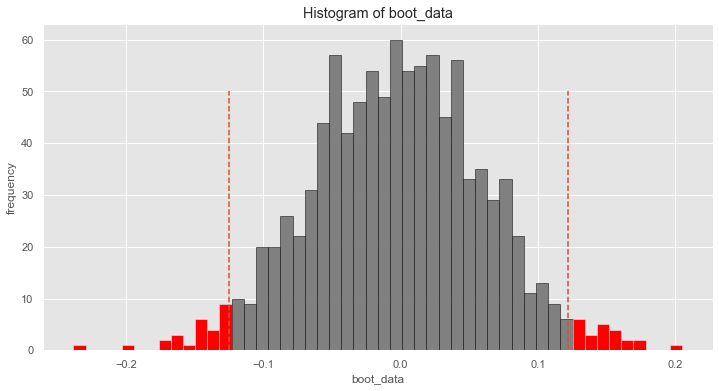

In [94]:
booted_data = get_bootstrap(t, c)

In [95]:
booted_data["p_value"] # альфа

0.9732198791304323

Нулевая гипотеза (H0): Разницы между средним value в тестовой и контрольной группе нет (зарабатывать больше не стали)

p > 0.05 . нулевую гипотезу не отвергаем

In [96]:
booted_data["quants"] # ДИ

,0
0.025,-0.125010
0.975,0.121768


Среднее зависит от выбросов. Можно использовать медиану

  0%|          | 0/1000 [00:00<?, ?it/s]

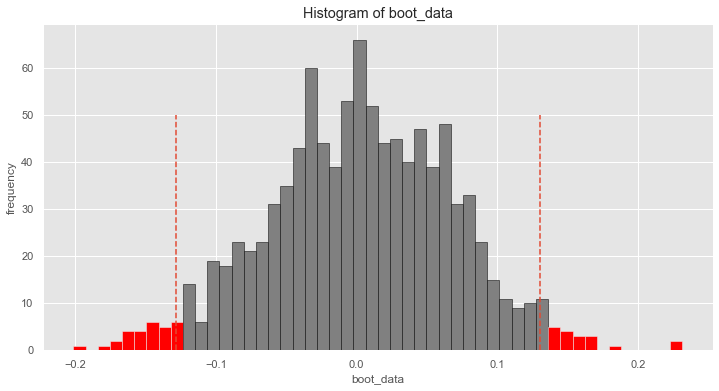

In [97]:
booted_data = get_bootstrap(hw[hw.experimentVariant == 'Treatment'].value, hw[hw.experimentVariant == 'Control'].value, statistic=np.median)

In [98]:
booted_data["p_value"] # альфа

0.963870136391872

In [100]:
booted_data["quants"] # ДИ

,0
0.025,-0.128339
0.975,0.130137


Нулевая гипотеза (H0): Разницы между средним value в тестовой и контрольной группе нет (зарабатывать больше не стали)

p > 0.05 . нулевую гипотезу не отвергаем

Когда мы используем бустрап стат.среднее (стоит по дефолту) На данных гдеыбросы сохранили, видна разница. И мы не отвергаем альтернативную гипотезу. 

Если будем брать не среднее, а медиану (что более корректно) в случае выбросов. то нулевую гипотезу мы не отвергаем.


В случае нличия выбросов, то среднее мы использовать не можем. 

Посмотрим значение p-value через:
boot mean
boot median
Mann Whitney

Для удобства сделаем это через цикл

  0%|          | 0/1000 [00:00<?, ?it/s]

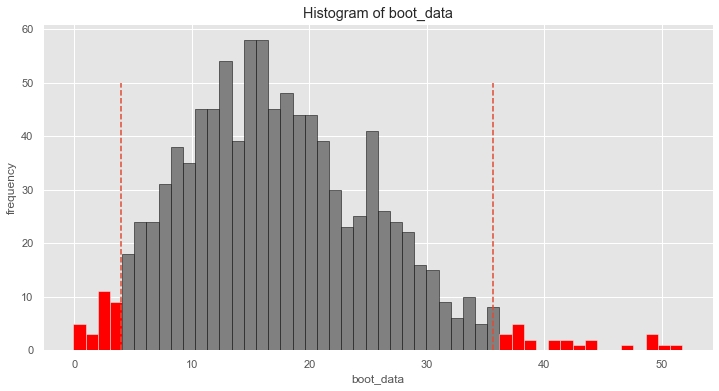

  0%|          | 0/1000 [00:00<?, ?it/s]

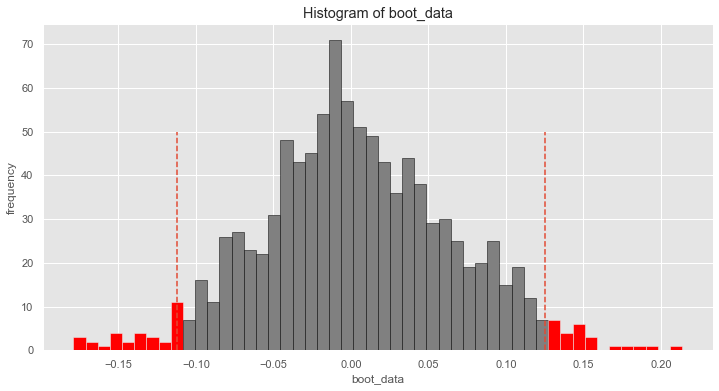

Boot mean: 0.03712094780534988, Boot median: 0.950153870440557, Mann Whitney: MannwhitneyuResult(statistic=125810.5, pvalue=0.8592148582485579)


  0%|          | 0/1000 [00:00<?, ?it/s]

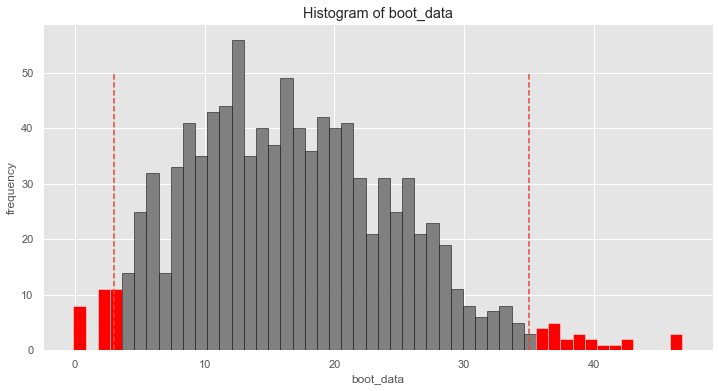

  0%|          | 0/1000 [00:00<?, ?it/s]

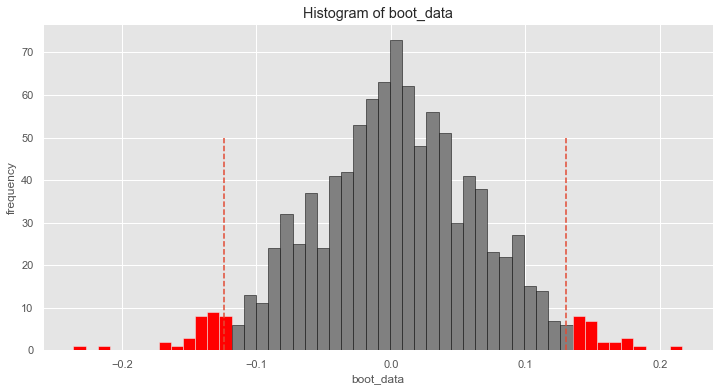

Boot mean: 0.040403223108799124, Boot median: 0.9489885608726317, Mann Whitney: MannwhitneyuResult(statistic=125810.5, pvalue=0.8592148582485579)


  0%|          | 0/1000 [00:00<?, ?it/s]

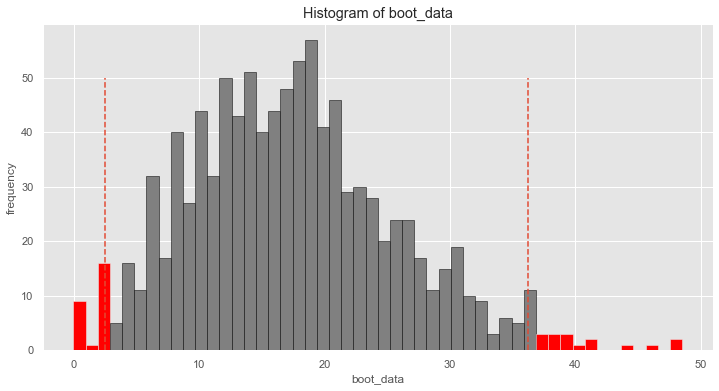

  0%|          | 0/1000 [00:00<?, ?it/s]

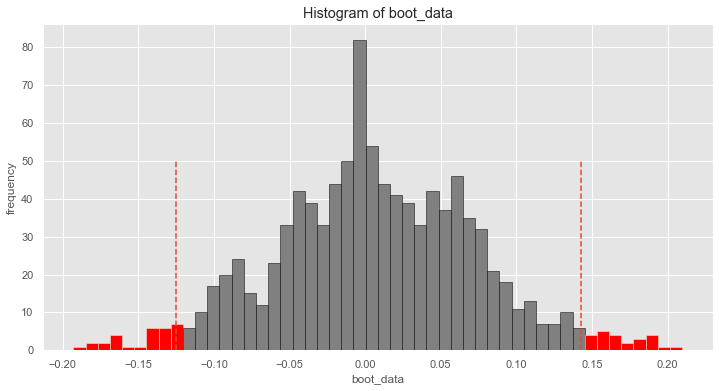

Boot mean: 0.035611367929624826, Boot median: 0.9202273497281597, Mann Whitney: MannwhitneyuResult(statistic=125810.5, pvalue=0.8592148582485579)


  0%|          | 0/1000 [00:00<?, ?it/s]

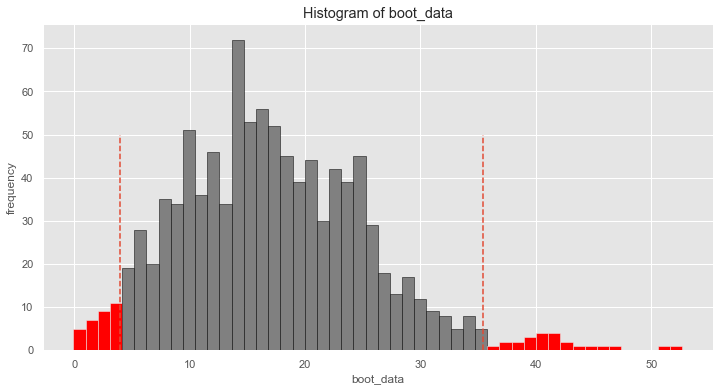

  0%|          | 0/1000 [00:00<?, ?it/s]

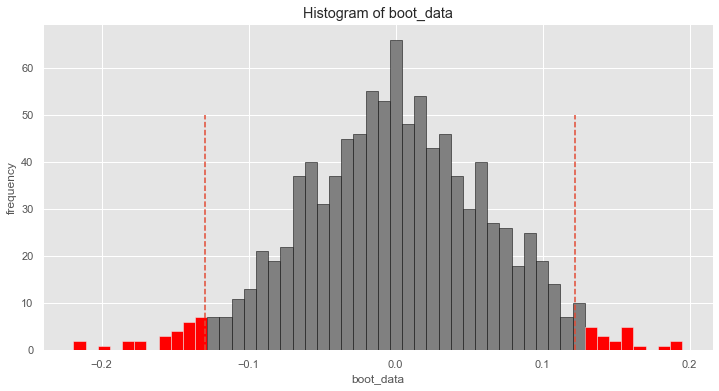

Boot mean: 0.03529162021534779, Boot median: 0.9999028200954964, Mann Whitney: MannwhitneyuResult(statistic=125810.5, pvalue=0.8592148582485579)


  0%|          | 0/1000 [00:00<?, ?it/s]

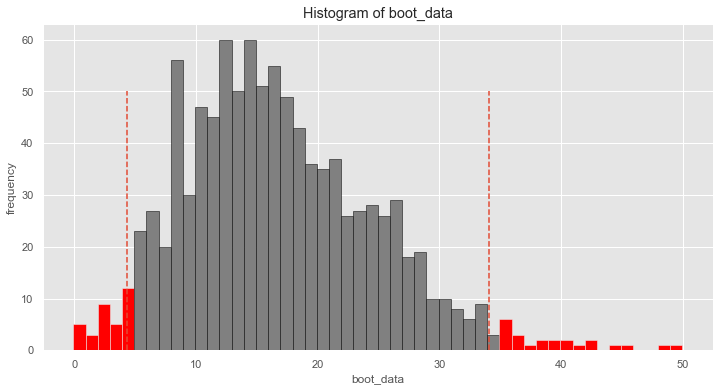

  0%|          | 0/1000 [00:00<?, ?it/s]

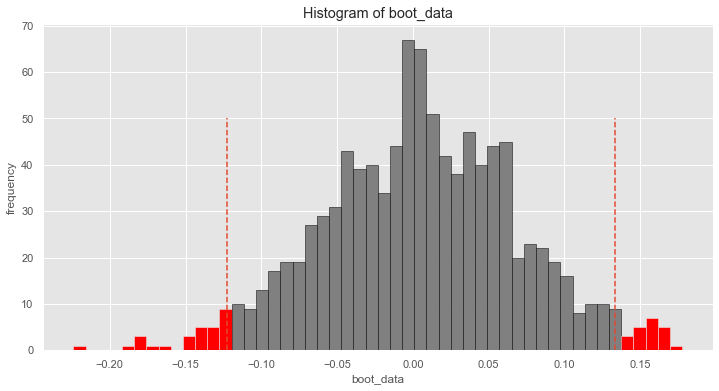

Boot mean: 0.03272117601331757, Boot median: 0.9373637870223301, Mann Whitney: MannwhitneyuResult(statistic=125810.5, pvalue=0.8592148582485579)


In [101]:
x = hw['value'][(hw['experimentVariant'] == 'Treatment')]
y = hw['value'][(hw['experimentVariant'] == 'Control')]

result_Mann = mannwhitneyu(x, y, alternative='two-sided')

for i in range(5):
    res_boot_mean = get_bootstrap(x, y)
    res_boot_median = get_bootstrap(hw[hw.experimentVariant == 'Treatment'].value, hw[hw.experimentVariant == 'Control'].value, statistic=np.median)
    
    
    print(f'Boot mean: {res_boot_mean ["p_value"]}, Boot median: {res_boot_median ["p_value"]}, Mann Whitney: {result_Mann}')

ВЫВОДЫ

1.Сравнивая средние с помощью бустрапа p-value находится примерно [0.03 - 0.04] И получается,
что мы можем отвергать нулевую гипотезу.

Однако с медианами так не вышло: p-value примерно [0.92 - 0.99]. Можно заметить, что 

- p-value по бутстрапу относительно близки к p-value по M.W [0.859].

Гипотеза по M.W проверяет наличие/отсутствие разницы между распределениями. Переводим выборку в ранговый вид,
и смтрим ранги в иссл. выборках. Медианы не отличаются по бутсрапу,  и M.W(точнее значения близки)
Бутстрап информативнее M.W,т.к. сохраняется дисперсия, в M.W дисперсия не учитывается. 

2. Делать t-test и бутстрап по среднему в данном случаем не корректно. Методы чувствительны к выбросам. 
Т.к. само среднее чувствительно. 

3. Если хотим работать с двумя методами выше (пункт 2). Нужно "избавиться " от аномалий, ну и привести  даные к нормальнму
распределению(особенно вслучае t-test).

4. M.W и бутстрап по медиане можно использовать на "сырых" данных. Однако M.W - не настолько информативен. 

5. Сравнивая значения p-value, мы не отвергаем нулевую гипотезу. И можно заключить, что нет зарабатывать больше
мы не стали


